In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
import re
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df=pd.read_csv('dataset/Spam SMS Collection',sep='\t',names=['type', 'message'])

In [3]:
df.head()

,type,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   type     5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


There are no missing values in the dataset,since it is shown in the info table.

In [6]:
df.describe()

,type,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
df['type'] = df['type'].map({'ham': 0, 'spam': 1})

In [8]:
df

,type,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


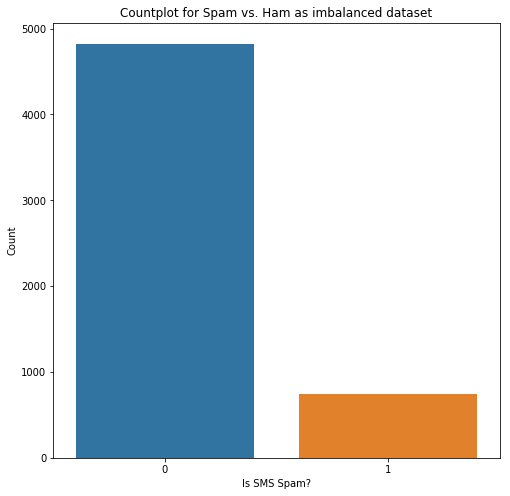

In [9]:
plt.figure(figsize=(8,8))
g = sns.countplot(x='type', data=df)
p = plt.title('Countplot for Spam vs. Ham as imbalanced dataset')
p = plt.xlabel('Is SMS Spam?')
p = plt.ylabel('Count')

Here the dataset is imbalanced.

In [10]:
print("Ham Count :",df['type'].value_counts()[0])
print("spam Count :",df['type'].value_counts()[1])

Ham Count : 4825
spam Count : 747


In [11]:
only_spam = df[df['type']==1]
count = int((df.shape[0]-only_spam.shape[0])/only_spam.shape[0])
for i in range(0, count-1):
    df = pd.concat([df, only_spam])

df.shape

(9307, 2)

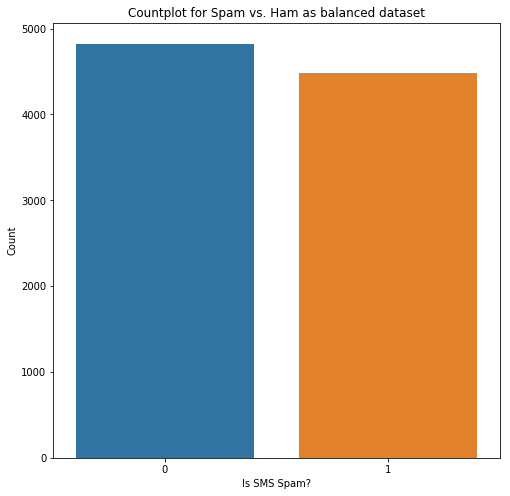

In [12]:
plt.figure(figsize=(8,8))
g = sns.countplot(x='type', data=df)
p = plt.title('Countplot for Spam vs. Ham as balanced dataset')
p = plt.xlabel('Is SMS Spam?')
p = plt.ylabel('Count')

In [13]:
# Creating new feature word_count
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

In [14]:
df.head()

,type,message,word_count
0,0,"Go until jurong point, crazy.. Available only ...",20
1,0,Ok lar... Joking wif u oni...,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,0,U dun say so early hor... U c already then say...,11
4,0,"Nah I don't think he goes to usf, he lives aro...",13


D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\anaconda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
D:\anaconda\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]

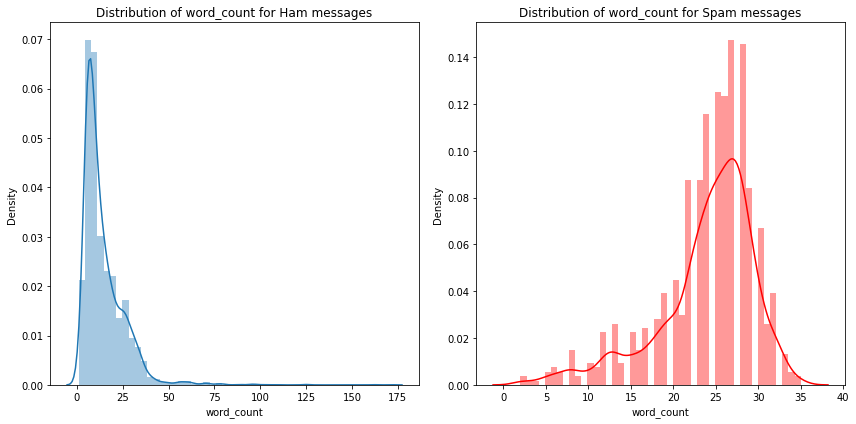

In [15]:
plt.figure(figsize=(12, 6))

# 1-row, 2-column, go to the first subplot
plt.subplot(1, 2, 1)
g = sns.distplot(a=df[df['type']==0].word_count)
p = plt.title('Distribution of word_count for Ham messages')

# 1-row, 2-column, go to the second subplot
plt.subplot(1, 2, 2)
g = sns.distplot(a=df[df['type']==1].word_count, color='red')
p = plt.title('Distribution of word_count for Spam messages')

plt.tight_layout()
plt.show()

**Spam messages** word_count fall in the range of **15-30 words**, whereas majority of the **Ham messages** fall in the range of **below 25 words**

In [16]:
# Creating feature contains_currency_symbol
def currency(x):
  currency_symbols = ['€', '$', '¥', '£', '₹']
  for i in currency_symbols:
    if i in x:
      return 1
  return 0

df['contains_currency_symbol'] = df['message'].apply(currency)

In [17]:
df.head()

,type,message,word_count,contains_currency_symbol
0,0,"Go until jurong point, crazy.. Available only ...",20,0
1,0,Ok lar... Joking wif u oni...,6,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28,0
3,0,U dun say so early hor... U c already then say...,11,0
4,0,"Nah I don't think he goes to usf, he lives aro...",13,0


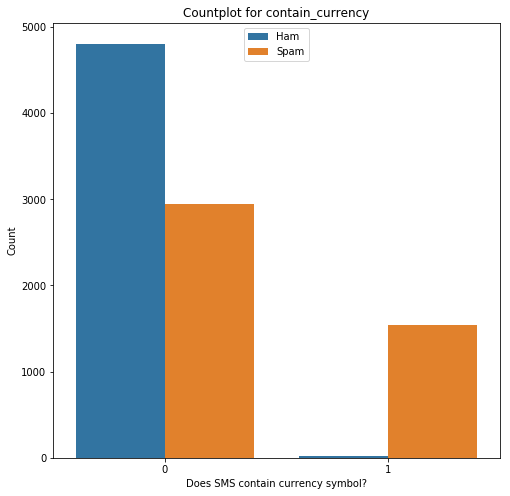

In [18]:
# Countplot for contains_currency_symbol
plt.figure(figsize=(8,8))
g = sns.countplot(x='contains_currency_symbol', data=df, hue='type')
p = plt.title('Countplot for contain_currency')
p = plt.xlabel('Does SMS contain currency symbol?')
p = plt.ylabel('Count')
p = plt.legend(labels=['Ham', 'Spam'], loc=9)

Almost 1/3 of Spam messages contain currency symbols, and currency symbols are rarely used in Ham messages.

In [19]:
# Creating feature contains_number
def numbers(x):
  for i in x:
    if ord(i)>=48 and ord(i)<=57:
      return 1
  return 0

df['contains_number'] = df['message'].apply(numbers)

In [20]:
df.head()

,type,message,word_count,contains_currency_symbol,contains_number
0,0,"Go until jurong point, crazy.. Available only ...",20,0,0
1,0,Ok lar... Joking wif u oni...,6,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28,0,1
3,0,U dun say so early hor... U c already then say...,11,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",13,0,0


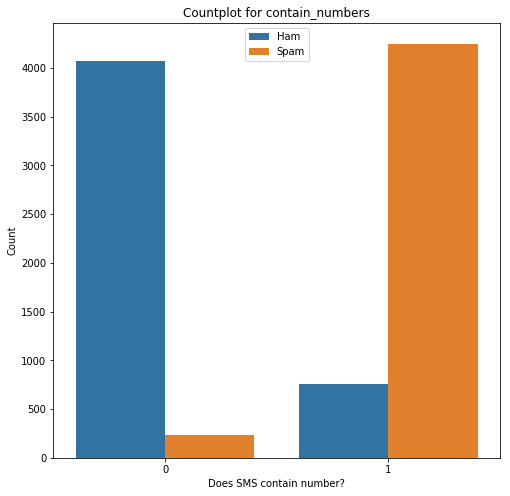

In [21]:
# Countplot for contains_number
plt.figure(figsize=(8,8))
g = sns.countplot(x='contains_number', data=df, hue='type')
p = plt.title('Countplot for contain_numbers')
p = plt.xlabel('Does SMS contain number?')
p = plt.ylabel('Count')
p = plt.legend(labels=['Ham', 'Spam'], loc=9)

It is evident that most of the Spam messages contain numbers, and majority of the Ham messages donot contain numbers.

# **Data Cleaning**
* Removing special character and numbers using regular expression
* Converting the entire sms into lower case
* Tokenizing the sms by words
* Removing the stop words
* Lemmatizing the words
* Joining the lemmatized words
* Building a corpus of messages

In [22]:
# Cleaning the messages
corpus = []
wnl = WordNetLemmatizer()

for sms_string in list(df.message):

  # Cleaning special character from the sms
  message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms_string)

  # Converting the entire sms into lower case
  message = message.lower()

  # Tokenizing the sms by words
  words = message.split()

  # Removing the stop words
  filtered_words = [word for word in words if word not in set(stopwords.words('english'))]

  # Lemmatizing the words
  lemmatized_words = [wnl.lemmatize(word) for word in filtered_words]

  # Joining the lemmatized words
  message = ' '.join(lemmatized_words)

  # Building a corpus of messages
  corpus.append(message)

In [23]:
corpus[0:5]

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf life around though']

In [24]:
tfidf = TfidfVectorizer(max_features=500)
vectors = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names()


In [25]:
# Extracting independent and dependent variables from the dataset
X = pd.DataFrame(vectors, columns=feature_names)
y = df['type']

# Model Building & Evaluation
Metric: F1-Score

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
mnb = MultinomialNB()
cv = cross_val_score(mnb, X, y, scoring='f1', cv=10)
print('--- Average F1-Score for MNB model: {} ---'.format(round(cv.mean(), 3)))
print('Standard Deviation: {}'.format(round(cv.std(), 3)))

--- Average F1-Score for MNB model: 0.943 ---
Standard Deviation: 0.004


In [28]:
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

print('--- Classification report for MNB model ---')
print(classification_report(y_test, y_pred))

--- Classification report for MNB model ---
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1457
           1       0.94      0.94      0.94      1336

    accuracy                           0.94      2793
   macro avg       0.94      0.94      0.94      2793
weighted avg       0.94      0.94      0.94      2793



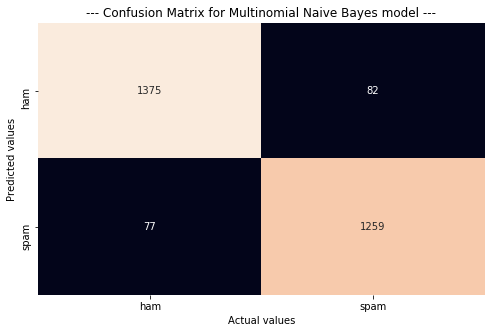

In [29]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
g = sns.heatmap(data=cm, annot=True,cbar=False, xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
p = plt.xlabel('Actual values')
p = plt.ylabel('Predicted values')
p = plt.title('--- Confusion Matrix for Multinomial Naive Bayes model ---')

In [30]:
dt = DecisionTreeClassifier()
cv = cross_val_score(dt, X, y, scoring='f1', cv=10)
print('--- Average F1-Score for Decision Tree model: {} ---'.format(round(cv.mean(), 3)))
print('Standard Deviation: {}'.format(round(cv.std(), 3)))

--- Average F1-Score for Decision Tree model: 0.982 ---
Standard Deviation: 0.004


In [31]:
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print('--- Classification report for Decision Tree model ---')
print(classification_report(y_test, y_pred))

--- Classification report for Decision Tree model ---
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1457
           1       0.96      0.99      0.97      1336

    accuracy                           0.98      2793
   macro avg       0.98      0.98      0.98      2793
weighted avg       0.98      0.98      0.98      2793



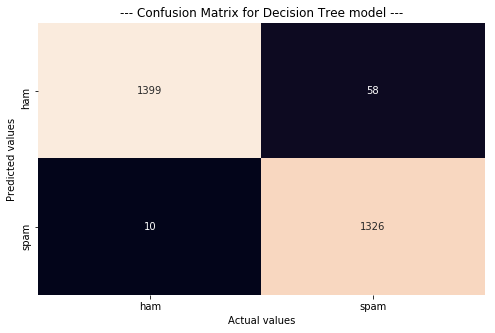

In [32]:
# Confusion matrix of Decision Tree model
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
g = sns.heatmap(data=cm, annot=True, cbar=False, xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
p = plt.xlabel('Actual values')
p = plt.ylabel('Predicted values')
p = plt.title('--- Confusion Matrix for Decision Tree model ---')

In [33]:
rf = RandomForestClassifier(n_estimators=10)
cv = cross_val_score(rf, X, y, scoring='f1', cv=10)
print('--- Average F1-Score for Random Forest model: {} ---'.format(round(cv.mean(), 3)))
print('Standard Deviation: {}'.format(round(cv.std(), 3)))

--- Average F1-Score for Random Forest model: 0.995 ---
Standard Deviation: 0.003


In [34]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('--- Classification report for Random Forest model ---')
print(classification_report(y_test, y_pred))

--- Classification report for Random Forest model ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1457
           1       0.99      0.99      0.99      1336

    accuracy                           0.99      2793
   macro avg       0.99      0.99      0.99      2793
weighted avg       0.99      0.99      0.99      2793



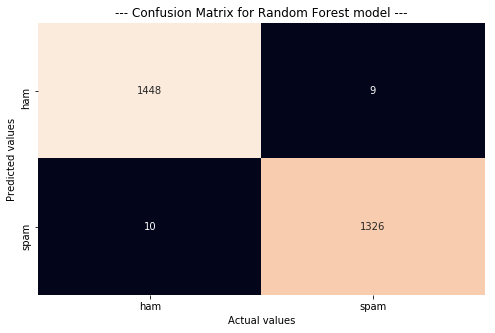

In [35]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
g = sns.heatmap(data=cm, annot=True, cbar=False, xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
p = plt.xlabel('Actual values')
p = plt.ylabel('Predicted values')
p = plt.title('--- Confusion Matrix for Random Forest model ---')

Decision Tree & MNB algorithms are selected and fed to Voting algorithm to increase the F1-Score!

In [36]:
# Fitting Decision Tree and MNB to VotingClassifier
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([('decision_tree', dt), ('m_naive_bayes', mnb)], weights=[2,1])
cv = cross_val_score(vc, X, y, cv=10, scoring='f1')

print('--- Average F1-Score for VotingClassifier model: {} ---'.format(round(cv.mean(), 3)))
print('Standard Deviation: {}'.format(round(cv.std(), 3)))

--- Average F1-Score for VotingClassifier model: 0.98 ---
Standard Deviation: 0.003


In [47]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Algorithms ", " Average F1 Score(percentage) ")
tb.add_row(["Multiomail Naive Bayes", 94.3])
tb.add_row(["Decision Tree", 98.0])
tb.add_row(["Random Forest",99.5])
tb.add_row(["Voting (Multinomial Naive Bayes + Decision Tree)", 98.0 ])
print(tb.get_string(titles = "Observations")) 

+--------------------------------------------------+--------------------------------+
|                    Algorithms                    |  Average F1 Score(percentage)  |
+--------------------------------------------------+--------------------------------+
|              Multiomail Naive Bayes              |              94.3              |
|                  Decision Tree                   |              98.0              |
|                  Random Forest                   |              99.5              |
| Voting (Multinomial Naive Bayes + Decision Tree) |              98.0              |
+--------------------------------------------------+--------------------------------+


Voting algorithm did not out-perform Random Forest algorithm, hence **Random Forest algorithm is selected for predicting the results of this problem statement.**

# Making predictions

In [37]:
def predict_spam(sample_message):
    sample_message = re.sub(pattern='[^a-zA-Z]',repl=' ', string = sample_message)
    sample_message = sample_message.lower()
    sample_message_words = sample_message.split()
    sample_message_words = [word for word in sample_message_words if not word in set(stopwords.words('english'))]
    final_message = [wnl.lemmatize(word) for word in sample_message_words]
    final_message = ' '.join(final_message)

    temp = tfidf.transform([final_message]).toarray()
    return rf.predict(temp)

In [49]:
# Prediction 1 - Lottery text message
sample_message = 'IMPORTANT - You could be entitled up to £3,1600  in compensation from mis-sold PPI on a credit card or loan. Please reply PPI for info or STOP to opt out.'

if predict_spam(sample_message):
    print('warning! This is a SPAM message.')
else:
    print('This is a normal message.')

warning! This is a SPAM message.


In [50]:
# Prediction 2 - Casual text chat
sample_message = 'Came to think of it. I have never got a spam message before.'

if predict_spam(sample_message):
    print('warning! This is a SPAM message.')
else:
    print('This is a normal message.')

This is a normal message.


In [51]:
# Prediction 3 - Transaction confirmation text message
sample_message = 'Sam, your rent payment for Jan 19 has been received. $1,300 will be drafted from your Wells Fargo Account ******0000 within 24-48 business hours. Thank you!'

if predict_spam(sample_message):
    print('warning! This is a SPAM message.')
else:
    print('This is a normal message.')

This is a normal message.


In [52]:
# Predicting values 4 - Feedback message
sample_message = 'Tammy, thanks for choosing Carl’s Car Wash for your express polish. We would love to hear your thoughts on the service. Feel free to text back with any feedback. Safe driving!'

if predict_spam(sample_message):
    print('warning! This is a SPAM message.')
else:
    print('This is a normal message.')

warning! This is a SPAM message.
